In [79]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)


Text(0.5, 0, 'Time (s)')

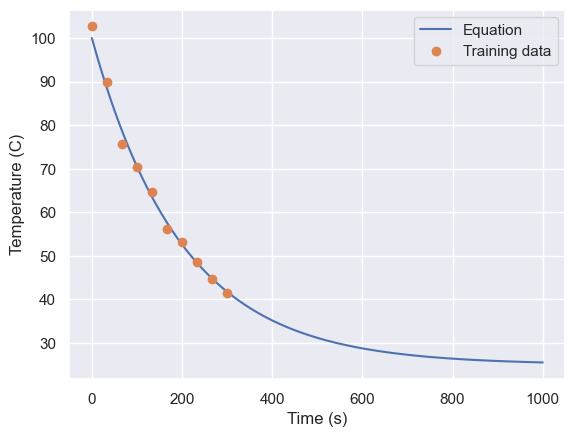

In [80]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# Vanilla Networks

Epoch 0/20000, loss: 4712.53
Epoch 2000/20000, loss: 2485.00
Epoch 4000/20000, loss: 2072.09
Epoch 6000/20000, loss: 596.94
Epoch 8000/20000, loss: 10.24
Epoch 10000/20000, loss: 2.72
Epoch 12000/20000, loss: 2.35
Epoch 14000/20000, loss: 2.34
Epoch 16000/20000, loss: 2.34
Epoch 18000/20000, loss: 1.71


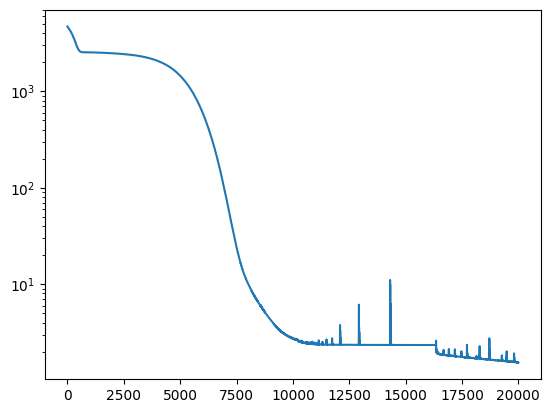

In [64]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [65]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, loss: 11232.34
Epoch 2000/20000, loss: 3896.21
Epoch 4000/20000, loss: 2375.50
Epoch 6000/20000, loss: 1506.33
Epoch 8000/20000, loss: 1067.17
Epoch 10000/20000, loss: 883.97
Epoch 12000/20000, loss: 810.39
Epoch 14000/20000, loss: 753.78
Epoch 16000/20000, loss: 702.20
Epoch 18000/20000, loss: 647.37


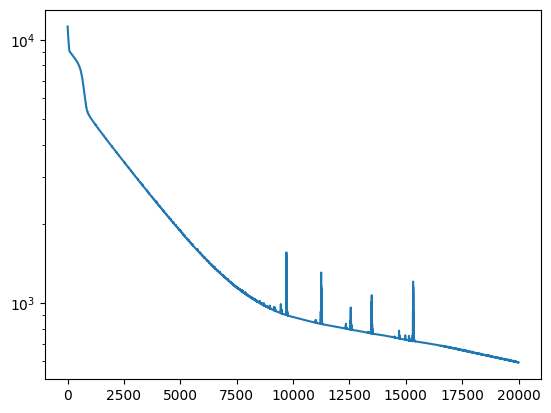

In [75]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

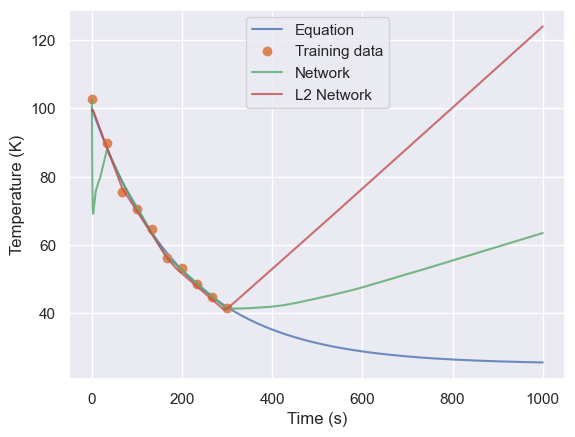

In [82]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')


# PINN

In [83]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4386.97
Epoch 3000/30000, loss: 2170.79
Epoch 6000/30000, loss: 60.89
Epoch 9000/30000, loss: 3.19
Epoch 12000/30000, loss: 2.91
Epoch 15000/30000, loss: 2.63
Epoch 18000/30000, loss: 2.32
Epoch 21000/30000, loss: 2.09
Epoch 24000/30000, loss: 1.87
Epoch 27000/30000, loss: 1.34


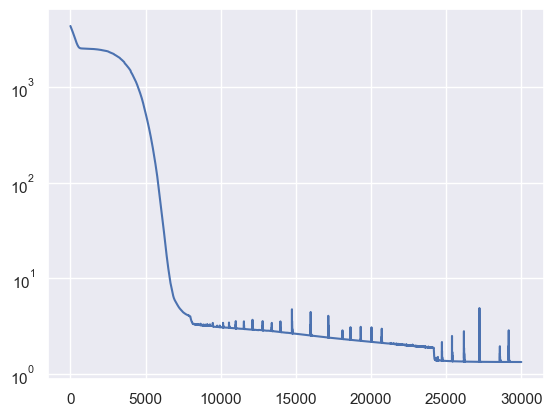

In [120]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

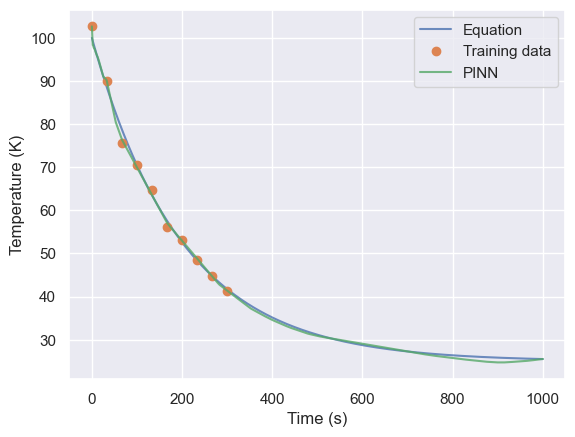

In [121]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# Parameter discovery

In [86]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/40000, loss: 4398.33
Epoch 4000/40000, loss: 2600.21
Epoch 8000/40000, loss: 1932.91
Epoch 12000/40000, loss: 267.44
Epoch 16000/40000, loss: 3.69
Epoch 20000/40000, loss: 2.14
Epoch 24000/40000, loss: 1.67
Epoch 28000/40000, loss: 1.47
Epoch 32000/40000, loss: 1.35
Epoch 36000/40000, loss: 1.32


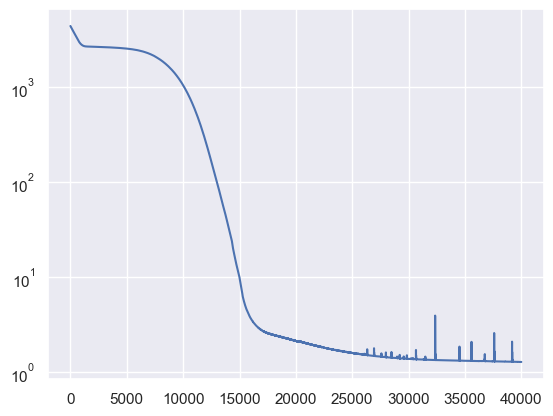

In [143]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0054], requires_grad=True)


Text(0.5, 0, 'Time (s)')

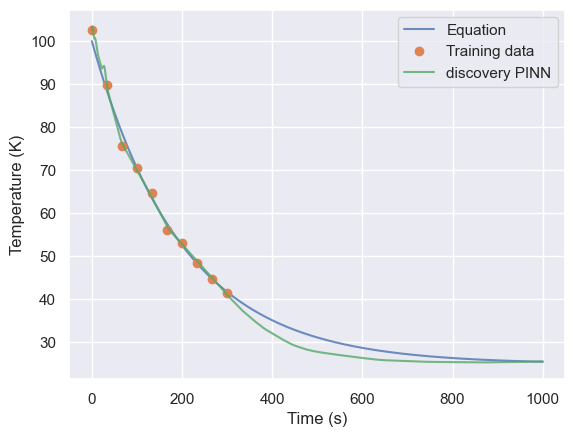

In [144]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')